# 20.260 Final Project
Rachit Mukkamala

May 8th, 2022

## Imports

In [1]:
import numpy as np
from scipy import stats
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, ClassifierMixin

from gprofiler import GProfiler

## Data Pre-processing and Cleaning

### Creating "X" Proteome Matrix

In [2]:
proteome_raw = pd.read_csv('SCC_Proteomics_Raw.csv', index_col='ProteinGroup')
proteome_raw.head()

,Accession,Accession_RNA,Accession_Protein,GeneID,Symbol,Alias,Type,Location,Description,Pool_TMT01-126,...,SCC091,Pool_TMT28-129,SCC106,SCC067,Pool_TMT29-126,SCC094,SCC068,SCC056,Pool_TMT29-130,SCC077
ProteinGroup,,,,,,,,,,,,,,,,,,,,,
1,NP_060547.2,NM_018077,NP_060547,55131,RBM28,ANES,protein-coding,7q32.1,RNA binding motif protein 28,17.273787,...,17.447064,17.426061,17.455934,17.312332,17.273787,17.128487,17.264057,17.479362,17.591378,17.584544
2,NP_060416.1,NM_017946,NP_060416,55033,FKBP14,EDSKMH FKBP22 IPBP12,protein-coding,7p14.3,FK506 binding protein 14,16.192072,...,NaN,NaN,NaN,NaN,16.192072,16.915128,16.252954,16.679773,16.090845,16.321976
3,NP_055986.1,NM_015171,NP_055986,23214,XPO6,EXP6 RANBP20,protein-coding,16p12.1,exportin 6,NaN,...,16.180924,16.116909,15.871284,15.234753,NaN,NaN,NaN,NaN,NaN,NaN
4,NP_001186284.1;NP_001186269.1;NP_001186270.1;N...,NM_000985 NM_001035006 NM_001199340 NM_0011993...,NP_000976 NP_001030178 NP_001186269 NP_0011862...,6139 100526842,RPL17 RPL17-C18orf32,L17 PD-1 RPL23,protein-coding,18q21.1,ribosomal protein L17 ||| RPL17-C18orf32 readt...,17.120808,...,17.361961,17.074857,17.229758,17.266270,17.120808,17.523670,17.648699,16.981810,17.139592,17.706366
5,NP_757365.1;XP_005253879.1;XP_016874188.1;NP_7...,NM_153500 NM_172215 NM_172216 XM_005253822 XM_...,NP_705720 NP_757364 NP_757365 XP_005253879 XP_...,10645,CAMKK2,CAMKK CAMKKB,protein-coding,12q24.31,calcium/calmodulin dependent protein kinase ki...,18.547656,...,19.327518,18.319514,18.039635,18.624117,18.547656,18.391208,19.082825,17.584927,18.366344,18.830776


In [3]:
proteome_raw.drop(axis=1, labels=['Type', 'Alias', 'Location', 'Description', 'GeneID', 'Accession', 'Accession_RNA', 'Accession_Protein'], inplace=True)
proteome_raw.rename({'Symbol':'Gene'}, axis=1, inplace=True)
proteome_raw.set_index('Gene', inplace=True)
proteome_raw = proteome_raw.filter(axis=1, regex='^SCC')
proteome_raw

,SCC015,SCC047,SCC024,SCC050,SCC071,SCC045,SCC037,SCC034,SCC097,SCC041,...,SCC085,SCC054,SCC061,SCC091,SCC106,SCC067,SCC094,SCC068,SCC056,SCC077
Gene,,,,,,,,,,,,,,,,,,,,,
RBM28,16.889623,17.189472,16.892350,17.300795,17.234488,17.097396,16.907567,17.128435,17.329093,17.044138,...,17.407958,17.132113,17.233958,17.447064,17.455934,17.312332,17.128487,17.264057,17.479362,17.584544
FKBP14,16.938783,15.985317,16.480067,16.452334,16.659608,16.697125,16.715386,16.426063,16.138976,16.401019,...,NaN,NaN,NaN,NaN,NaN,NaN,16.915128,16.252954,16.679773,16.321976
XPO6,NaN,NaN,NaN,NaN,15.852808,16.042092,15.858399,15.163129,16.255776,16.147329,...,NaN,NaN,15.219777,16.180924,15.871284,15.234753,NaN,NaN,NaN,NaN
RPL17 RPL17-C18orf32,16.888385,17.352243,17.022111,16.902223,17.314238,16.939446,17.211756,17.201093,17.242390,17.013219,...,17.150964,16.994211,17.171199,17.361961,17.229758,17.266270,17.523670,17.648699,16.981810,17.706366
CAMKK2,19.123142,19.761374,16.733707,18.485759,18.600312,18.976330,17.753977,18.333589,18.375168,18.141389,...,NaN,NaN,17.822484,19.327518,18.039635,18.624117,18.391208,19.082825,17.584927,18.830776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGPS1,16.763534,16.886334,16.472210,17.018725,16.726634,16.977017,16.753149,17.008707,17.074202,15.626651,...,16.213728,17.100166,16.869562,16.897639,16.672674,16.714330,16.874627,16.860557,17.209037,17.054983
---,15.767608,16.014954,16.949765,15.485975,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLOC1S1,16.952873,16.981147,17.308414,16.652744,17.065437,16.987564,17.018330,17.090743,16.960304,16.903482,...,16.766255,16.917097,16.447641,16.742878,16.833987,16.907604,16.522119,16.836239,16.639692,16.944805


Text(0.5, 1.0, 'Number of Missing Values per Gene')

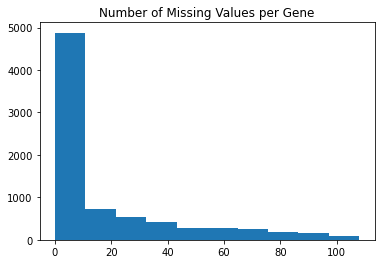

In [4]:
proteome_raw = proteome_raw.loc[proteome_raw.index != '---',]
plt.hist(np.sum(proteome_raw.isna(), axis=1))
plt.title('Number of Missing Values per Gene')

In [5]:
cutoff = 30
print(np.sum(np.sum(proteome_raw.isna(), axis=1) <= cutoff))

6045


Perhaps a good cutoff for number of missing values tolerated is <= 30.

In [6]:
proteome_raw = proteome_raw.loc[np.sum(proteome_raw.isna(), axis=1) <= cutoff,]
proteome_raw = proteome_raw.T
proteome_raw = proteome_raw.sort_index()
proteome_raw.to_csv('SCC_Predictor_Proteome_cleaned.csv')
proteome_raw

Gene,RBM28,XPO6,RPL17 RPL17-C18orf32,CAMKK2,RPL11,NUBP1,RCN3,HMCES,SET,MAPK14,...,HEXIM1,SLC38A2,OTUB1,IDH3B,CYP4F3,LSM4,GGPS1,BLOC1S1,PSMD11,LRRC8A
SCC001,17.455745,NaN,16.584837,NaN,17.761641,NaN,16.133312,16.224446,16.629587,16.704695,...,16.247303,16.256525,16.627917,16.697517,16.994888,17.356033,16.540088,16.824544,16.601595,17.183535
SCC002,17.247771,17.170001,17.317346,18.802867,18.047545,16.246081,14.396567,17.004690,16.875129,16.638189,...,16.497975,16.061816,16.830417,16.642156,17.010478,17.284266,18.409225,16.649383,16.570425,17.183928
SCC003,17.292971,NaN,16.746624,17.624122,17.560549,16.451195,15.781830,NaN,16.680993,16.379358,...,NaN,16.667169,16.639782,16.225933,16.298286,NaN,16.768196,16.684280,16.369291,17.068271
SCC004,17.400901,16.493280,17.034689,19.251126,17.844898,16.025109,15.710900,16.855962,16.632004,16.201638,...,16.662775,16.266898,16.702006,16.240624,17.246538,17.321641,17.038372,16.672531,16.549712,17.190188
SCC005,17.718988,16.087177,17.214013,18.768083,17.952424,15.427876,15.969803,17.467738,17.098376,16.169707,...,16.863503,15.622777,16.733236,15.757718,NaN,17.170831,16.161420,16.750601,16.513946,16.624117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCC104,17.429323,15.954692,17.293575,18.274294,18.030262,16.160025,15.755759,16.814176,16.936121,16.014830,...,16.964340,17.879744,17.163820,15.853371,16.547457,17.377458,16.780137,17.057844,16.551440,16.549346
SCC105,17.164285,15.115040,16.561446,18.846083,17.591559,15.955656,16.620868,17.598206,15.715289,16.438940,...,16.536133,NaN,16.397800,15.943563,16.974675,17.028827,16.656060,16.943693,16.184358,15.980314
SCC106,17.455934,15.871284,17.229758,18.039635,17.843238,16.313460,15.978992,17.062262,16.737803,16.302981,...,16.407613,17.001390,16.616104,15.286547,16.484571,NaN,16.672674,16.833987,16.480182,16.967470
SCC107,17.205638,NaN,16.903972,18.424616,17.483132,15.815929,16.132811,16.715602,16.750705,16.129228,...,16.827005,NaN,16.817004,16.033880,16.617265,17.126576,16.759561,16.695366,16.324489,16.544666


### Creating Y Matrix

In [7]:
clinical_raw = pd.read_csv('SCC_Clinical_Raw.csv', index_col = 'sample_name')
sel_yvars = ['Grade_Differentiation', 'Pathological_TNM_Group_Stage', 'Regional_Lymph_Nodes_examined', 
             'Regional_Lymph_Nodes_positive', 'Vital_Status__Final_', 'Recurrence__Final_']
             
clinical_raw = clinical_raw.filter(axis=1, items=sel_yvars)
clinical_raw = clinical_raw.rename({'Vital_Status__Final_': 'Death', 'Recurrence__Final_':'Recurrence', 
                                    'Pathological_TNM_Group_Stage':'Stage', 
                                    'Grade_Differentiation':'Differentiation'}, axis=1)
clinical_raw['Percent_Nodes_Positive'] = np.round((clinical_raw['Regional_Lymph_Nodes_positive'] / clinical_raw['Regional_Lymph_Nodes_examined'])*100, 1)
clinical_raw = clinical_raw.drop(axis=1, labels=['Regional_Lymph_Nodes_positive', 'Regional_Lymph_Nodes_examined'])
clinical_raw

,Differentiation,Stage,Death,Recurrence,Percent_Nodes_Positive
sample_name,,,,,
SCC019,MODERATELY DIFFEREN.,2A,Dead,0.0,0.0
SCC064,MODERATELY DIFFEREN.,2B,Alive,1.0,11.1
SCC061,POORLY DIFFEREN.,2A,Dead,0.0,0.0
SCC020,MODERATELY DIFFEREN.,2A,Alive,0.0,5.3
SCC048,MODERATELY DIFFEREN.,2A,Dead,NaN,11.5
...,...,...,...,...,...
SCC043,MODERATELY DIFFEREN.,2B,Dead,0.0,0.0
SCC072,MODERATELY DIFFEREN.,1A,Dead,0.0,0.0
SCC049,MODERATELY DIFFEREN.,3A,Alive,0.0,14.3


In [8]:
tumor_cellularity = pd.read_csv('SCC_Tumor_Cellularity.csv', index_col = 'sample_name')
tumor_cellularity = tumor_cellularity.rename({'tumor_cellularity_percentage':'Percent_Cellularity'}, axis=1)
clinical_raw = pd.merge(left=clinical_raw, right=tumor_cellularity, how='left', left_index=True, right_index=True)

cd20 = pd.read_csv('SCC_CD20.csv', index_col='sample_name')
cd20 = cd20.rename({'Total Positive':'Percent_CD20_Positive'}, axis=1)
cd20 = np.round(100*cd20['Percent_CD20_Positive'], 1)
clinical_raw = pd.merge(left=clinical_raw, right=cd20, how='left', left_index=True, right_index=True)

tln = pd.read_csv('SCC_HETLN.csv', index_col='sample_name')
tln = tln.rename({'TLN H&E Score':'TLN_Score'}, axis=1)
tln = tln['TLN_Score']
clinical_raw = pd.merge(left=clinical_raw, right=tln, how='left', left_index=True, right_index=True)

clinical_raw

,Differentiation,Stage,Death,Recurrence,Percent_Nodes_Positive,Percent_Cellularity,Percent_CD20_Positive,TLN_Score
sample_name,,,,,,,,
SCC019,MODERATELY DIFFEREN.,2A,Dead,0.0,0.0,80.0,10.4,2.0
SCC064,MODERATELY DIFFEREN.,2B,Alive,1.0,11.1,80.0,2.0,0.0
SCC061,POORLY DIFFEREN.,2A,Dead,0.0,0.0,95.0,5.2,NaN
SCC020,MODERATELY DIFFEREN.,2A,Alive,0.0,5.3,85.0,14.6,1.0
SCC048,MODERATELY DIFFEREN.,2A,Dead,NaN,11.5,70.0,2.8,0.0
...,...,...,...,...,...,...,...,...
SCC043,MODERATELY DIFFEREN.,2B,Dead,0.0,0.0,70.0,4.6,0.0
SCC072,MODERATELY DIFFEREN.,1A,Dead,0.0,0.0,80.0,8.3,0.0
SCC049,MODERATELY DIFFEREN.,3A,Alive,0.0,14.3,80.0,5.4,1.0


In [9]:
clinical_raw['Differentiation'].replace({'WELL DIFFERENTIATED': 1, 'MODERATELY DIFFEREN.':2, 
                                        'POORLY DIFFEREN.':3, 'UNDIFFERENTIATED':4, 
                                        'NOT DETERMINED OR NA':np.nan}, inplace=True)

clinical_raw['Stage'].replace({'1A':1, '1B':1.5, '2A':2, '2B':2.5, '3A':3, '3B':3.5}, inplace=True)
clinical_raw['Death'].replace({'Dead':1,'Alive':0}, inplace=True)
clinical_raw = clinical_raw.sort_index()

In [10]:
clinical_raw.to_csv('SCC_Outcome_Data_Processed.csv')
clinical_raw

,Differentiation,Stage,Death,Recurrence,Percent_Nodes_Positive,Percent_Cellularity,Percent_CD20_Positive,TLN_Score
sample_name,,,,,,,,
SCC001,2.0,1.5,1,0.0,0.0,90.0,25.3,2.0
SCC002,3.0,1.0,1,1.0,0.0,NaN,4.7,2.0
SCC003,3.0,1.0,0,0.0,0.0,NaN,3.5,1.0
SCC004,3.0,1.5,1,0.0,0.0,85.0,4.8,2.0
SCC005,3.0,2.0,0,0.0,0.0,70.0,5.1,2.0
...,...,...,...,...,...,...,...,...
SCC104,3.0,1.0,1,0.0,0.0,70.0,11.8,1.0
SCC105,2.0,2.0,0,0.0,0.0,80.0,7.8,2.0
SCC106,2.0,1.5,1,NaN,0.0,70.0,9.2,0.0


## Imputation of Y

In [11]:
#Impute missing Y values
clinical_raw = pd.read_csv('SCC_Outcome_Data_Processed.csv', index_col='sample_name')
Y = KNNImputer(n_neighbors=1).fit_transform(clinical_raw)
Y = pd.DataFrame(Y, index=clinical_raw.index, columns=clinical_raw.columns)
Y

,Differentiation,Stage,Death,Recurrence,Percent_Nodes_Positive,Percent_Cellularity,Percent_CD20_Positive,TLN_Score
sample_name,,,,,,,,
SCC001,2.0,1.5,1.0,0.0,0.0,90.0,25.3,2.0
SCC002,3.0,1.0,1.0,1.0,0.0,85.0,4.7,2.0
SCC003,3.0,1.0,0.0,0.0,0.0,75.0,3.5,1.0
SCC004,3.0,1.5,1.0,0.0,0.0,85.0,4.8,2.0
SCC005,3.0,2.0,0.0,0.0,0.0,70.0,5.1,2.0
...,...,...,...,...,...,...,...,...
SCC104,3.0,1.0,1.0,0.0,0.0,70.0,11.8,1.0
SCC105,2.0,2.0,0.0,0.0,0.0,80.0,7.8,2.0
SCC106,2.0,1.5,1.0,1.0,0.0,70.0,9.2,0.0


## Unsupervised Proteomics Data Exploration

As a brief first pass, I will impute the missing values in X using default of n=5, then scale, cluster with KMeans, and perform PCA.

In [12]:
proteome_raw = pd.read_csv('SCC_Predictor_Proteome_cleaned.csv', index_col=0)
X = KNNImputer(n_neighbors=5).fit_transform(proteome_raw)
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, index=proteome_raw.index, columns=proteome_raw.columns)
X

,RBM28,XPO6,RPL17 RPL17-C18orf32,CAMKK2,RPL11,NUBP1,RCN3,HMCES,SET,MAPK14,...,HEXIM1,SLC38A2,OTUB1,IDH3B,CYP4F3,LSM4,GGPS1,BLOC1S1,PSMD11,LRRC8A
SCC001,0.636152,0.940756,-1.885455,-0.209994,-0.070430,0.654327,1.247733,-2.034040,-0.795182,1.761594,...,-1.069698,-0.001492,-0.122094,2.081627,0.152052,0.282768,-0.670929,0.079226,0.425450,0.553250
SCC002,-0.049763,1.929477,0.862850,0.686079,1.175213,0.428692,-2.409013,-0.042245,-0.148047,1.540599,...,-0.206871,-0.383177,0.865156,1.886932,0.180027,-0.045042,3.967617,-0.685719,0.210783,0.554222
SCC003,0.099312,0.303080,-1.278442,-1.191401,-0.946563,1.167687,0.507682,-0.621423,-0.659698,0.680531,...,0.170805,0.803486,-0.064248,0.423136,-1.097968,-0.064481,-0.104846,-0.533322,-1.174423,0.268589
SCC004,0.455276,0.756073,-0.197654,1.400056,0.292307,-0.367439,0.358336,-0.421915,-0.788812,0.089983,...,0.360384,0.018841,0.239112,0.474803,0.603626,0.125676,0.565638,-0.584633,0.068129,0.569681
SCC005,1.504352,0.051907,0.475155,0.630677,0.760786,-2.519188,0.903460,1.139817,0.440329,-0.016121,...,1.051300,-1.243818,0.391368,-1.223505,-0.112715,-0.563176,-1.610652,-0.243691,-0.178187,-0.828318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCC104,0.549014,-0.177815,0.773665,-0.155821,1.099913,0.118643,0.452788,-0.528584,0.012700,-0.530764,...,1.398385,3.180476,2.490606,-0.887110,-0.650842,0.380631,-0.075213,1.098070,0.080033,-1.012976
SCC105,-0.325104,-1.633734,-1.973216,0.754912,-0.811459,-0.617668,2.274289,1.472873,-3.204848,0.878512,...,-0.075527,-0.629158,-1.243990,-0.569918,0.115781,-1.211810,-0.383126,0.599565,-2.448055,-2.418289
SCC106,0.636776,-0.322441,0.534230,-0.529579,0.285072,0.671447,0.922809,0.104726,-0.509975,0.426736,...,-0.517901,1.458653,-0.179688,-2.880544,-0.763689,-0.092223,-0.341898,0.120462,-0.410719,0.019646
SCC107,-0.188718,0.313298,-0.688088,0.083609,-1.283859,-1.121088,1.246677,-0.780222,-0.475972,-0.150627,...,0.925673,-0.396658,0.799766,-0.252286,-0.525574,-0.765320,-0.126274,-0.484910,-1.482969,-1.024534


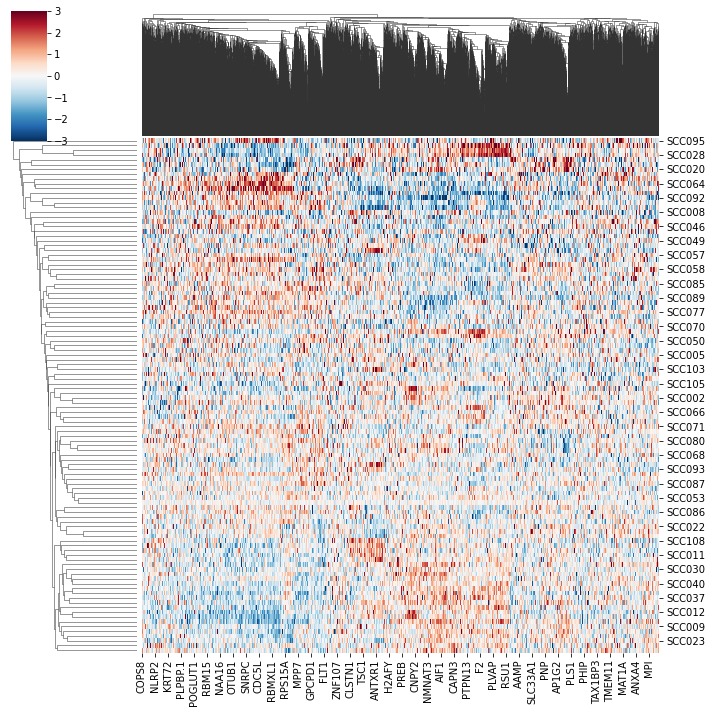

In [13]:
sns.clustermap(X, cmap='RdBu_r', center=0, vmin=-3, vmax=3)

In [14]:
def elbow_plot(X, ks, seed):
    scores = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X)
        scores.append(kmeans.inertia_)

    plt.plot(ks, scores)
    plt.title('Elbow Plot')
    plt.xlabel('K')
    plt.ylabel('Inertia (WCSS)')
    plt.show()

c:\Users\RackS\.conda\envs\datasci_env\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


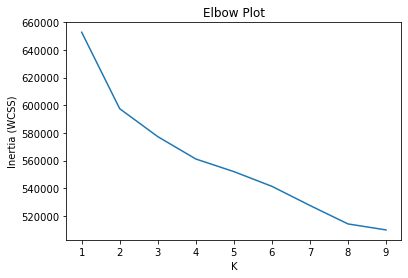

In [15]:
elbow_plot(X, range(1, 10), 3194)

Clearly, there is an elbow at K=2. Let's use PCA to visualize!

<AxesSubplot:>

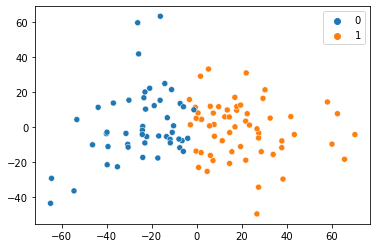

In [16]:
labels = KMeans(n_clusters=2).fit_predict(X)
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X)
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=labels)

Wow! This was a very clean clustering! Let's find the DE genes in each cluster.

In [17]:
def find_all_markers(X, labels):
    output = pd.DataFrame()
    for c_num in np.unique(labels):
        clust = X.loc[labels==c_num,]

        pvals = []
        changes = []
        for gene in range(X.shape[1]):
            ustat, pval = stats.mannwhitneyu(X.iloc[:,gene], clust.iloc[:,gene], alternative='two-sided')
            pvals.append(pval)
            changes.append(np.mean(clust.iloc[:,gene]))

        is_signif, pvals_adj = mne.stats.fdr_correction(pvals, alpha=0.05, method='indep')
        new_de_df = pd.DataFrame({'Gene':X.columns, 
                                  'P_Val': pvals_adj, 
                                  'Cluster':np.repeat(c_num, len(X.columns)),
                                  'Change': changes,
                                  'DE': is_signif})

        new_de_df = new_de_df[new_de_df['DE']]
        new_de_df = new_de_df.sort_values(by=['P_Val'], ascending=True)
        output = pd.concat([output, new_de_df], axis=0)

    return output

In [18]:
de_chart = find_all_markers(X, labels)

In [19]:
clust_a_up = de_chart[(de_chart['Cluster'] == 0) & (de_chart['Change'] > 0)]['Gene']
clust_a_down = de_chart[(de_chart['Cluster'] == 0) & (de_chart['Change'] < 0)]['Gene']

clust_b_up = de_chart[(de_chart['Cluster'] == 1) & (de_chart['Change'] > 0)]['Gene']
clust_b_down = de_chart[(de_chart['Cluster'] == 1) & (de_chart['Change'] < 0)]['Gene']

In [20]:
gp = GProfiler(return_dataframe=True)

In [21]:
def generate_go_df(query):
    go_res = gp.profile(organism='hsapiens', query=query.to_list())
    go_res = go_res.iloc[0:10, 0:6]
    return go_res

In [22]:
#Upregulated Pathways in Cluster A
generate_go_df(clust_a_up)['name']

0                       extracellular vesicle
1    extracellular membrane-bounded organelle
2                     extracellular organelle
3                       extracellular exosome
4                                     vesicle
5                         extracellular space
6                        extracellular region
7                       intracellular vesicle
8                         cytoplasmic vesicle
9                           secretory granule
Name: name, dtype: object

In [23]:
#Downregulated pathways in cluster A
generate_go_df(clust_a_down)['name']

0                                        nucleoplasm
1                                        RNA binding
2                                      nuclear lumen
3                      intracellular organelle lumen
4                                    organelle lumen
5                            membrane-enclosed lumen
6                                  Metabolism of RNA
7    Processing of Capped Intron-Containing Pre-mRNA
8                               nucleic acid binding
9                      mRNA Splicing - Major Pathway
Name: name, dtype: object

In [24]:
#Upregulated pathways in cluster B
generate_go_df(clust_b_up)['name']

0                                        nucleoplasm
1                                        RNA binding
2                                      nuclear lumen
3                               nucleic acid binding
4                      intracellular organelle lumen
5                            membrane-enclosed lumen
6                                    organelle lumen
7                      mRNA Splicing - Major Pathway
8    Processing of Capped Intron-Containing Pre-mRNA
9                                      mRNA Splicing
Name: name, dtype: object

In [25]:
#Downregulated pathways in cluster B
generate_go_df(clust_b_down)['name']

0                       extracellular exosome
1                       extracellular vesicle
2    extracellular membrane-bounded organelle
3                     extracellular organelle
4                                     vesicle
5                         extracellular space
6                        extracellular region
7                     cell-substrate junction
8                              focal adhesion
9                         blood microparticle
Name: name, dtype: object

Interesting! Looks like Cluster A and Cluster B are opposites of each other! Let's look at the loadings' pathway enrichments to confirm!

In [26]:
bottom_20 = X.columns[np.argsort(pca.components_[0,:])[0:21]]
top_20 = X.columns[np.argsort(pca.components_[0,:])[-1:-21:-1]]

In [27]:
#BOTTOM 20 (loadings pointing left)
gp.profile(bottom_20.to_list(), organism='hsapiens').iloc[0:10,0:6]

,source,native,name,p_value,significant,description
0,GO:CC,GO:0070062,extracellular exosome,8.338941e-13,True,"""A vesicle that is released into the extracell..."
1,GO:CC,GO:1903561,extracellular vesicle,1.000048e-12,True,"""Any vesicle that is part of the extracellular..."
2,GO:CC,GO:0043230,extracellular organelle,1.007934e-12,True,"""Organized structure of distinctive morphology..."
3,GO:CC,GO:0065010,extracellular membrane-bounded organelle,1.007934e-12,True,"""Organized structure of distinctive morphology..."
4,GO:CC,GO:0031982,vesicle,2.408645e-11,True,"""Any small, fluid-filled, spherical organelle ..."
5,GO:CC,GO:0005615,extracellular space,5.929499e-11,True,"""That part of a multicellular organism outside..."
6,GO:MF,GO:0005200,structural constituent of cytoskeleton,1.637869e-09,True,"""The action of a molecule that contributes to ..."
7,GO:CC,GO:0005576,extracellular region,4.789816e-09,True,"""The space external to the outermost structure..."
8,HPA,HPA:0030443,appendix; non-germinal center cells[High],9.500039e-09,True,appendix; non-germinal center cells[High]
9,GO:CC,GO:0015629,actin cytoskeleton,3.934653e-08,True,"""The part of the cytoskeleton (the internal fr..."


In [28]:
gp.profile(top_20.to_list(), organism='hsapiens').iloc[0:10,0:6]

,source,native,name,p_value,significant,description
0,GO:CC,GO:0005681,spliceosomal complex,1.585484e-14,True,"""Any of a series of ribonucleoprotein complexe..."
1,GO:CC,GO:0071013,catalytic step 2 spliceosome,2.636112e-13,True,"""A spliceosomal complex that contains three sn..."
2,REAC,REAC:R-HSA-72163,mRNA Splicing - Major Pathway,3.402397e-13,True,mRNA Splicing - Major Pathway
3,HPA,HPA:0570763,testis; pachytene spermatocytes[High],4.431555e-13,True,testis; pachytene spermatocytes[High]
4,REAC,REAC:R-HSA-72172,mRNA Splicing,5.326190e-13,True,mRNA Splicing
5,HPA,HPA:0570813,testis; spermatogonia cells[High],4.854159e-12,True,testis; spermatogonia cells[High]
6,REAC,REAC:R-HSA-72203,Processing of Capped Intron-Containing Pre-mRNA,6.229883e-12,True,Processing of Capped Intron-Containing Pre-mRNA
7,REAC,REAC:R-HSA-8953854,Metabolism of RNA,6.431031e-11,True,Metabolism of RNA
8,HPA,HPA:0570793,testis; round or early spermatids[High],6.895871e-11,True,testis; round or early spermatids[High]
9,WP,WP:WP411,mRNA processing,1.327729e-10,True,mRNA processing


CONCLUSION!!: The tumor samples can be split into two clusters based upon their production of extracellular proteins as well as production of mRNA metabolic and splicing proteins.

Cluster A (0): Exocytosis+/RNA metabolism-
Cluster B (1): Exocytosis-/RNA metabolism+

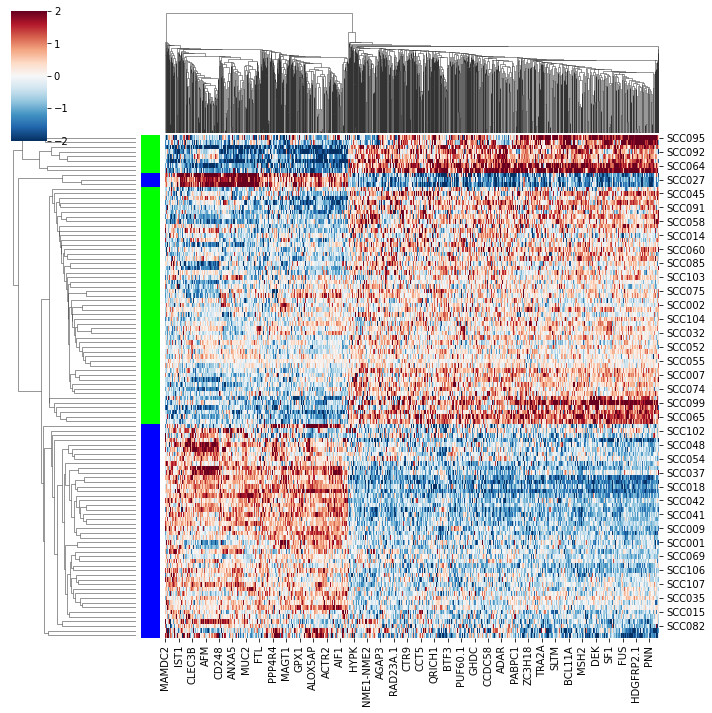

In [29]:
colormap = {0:[0,0,1], 1:[0,1,0]}
label_cols = [colormap[i] for i in labels]
sns.clustermap(X.loc[:, de_chart['Gene']], cmap='RdBu_r', vmin=-2, vmax=2, center=0, row_colors=label_cols)

## Supervised PLS Models

I will use the labels from the clustering as an outcome variable of sorts to quantify the quality of imputation. I will re-impute using a value of K that I determine using GridSearchCV.

In [30]:
pipeline = Pipeline(steps=[('imputer', KNNImputer()), ('predictor', RandomForestClassifier())])
gs = GridSearchCV(estimator = pipeline, param_grid={'imputer__n_neighbors': np.arange(2,14,2)}, scoring='roc_auc', cv=5)
gs.fit(proteome_raw, labels)
gs_res = pd.DataFrame(gs.cv_results_)
print(gs.best_estimator_, gs.best_score_)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('predictor', RandomForestClassifier())]) 0.9983333333333334


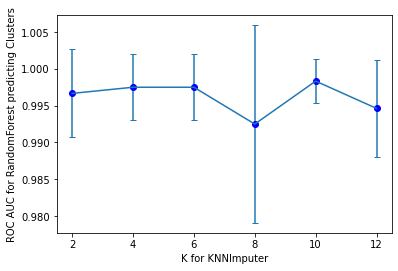

In [31]:
plt.plot(gs_res['param_imputer__n_neighbors'], gs_res['mean_test_score'], 'bo')
plt.errorbar(gs_res['param_imputer__n_neighbors'], gs_res['mean_test_score'], yerr = 2*gs_res['std_test_score']/np.sqrt(gs.cv), capsize=3)
plt.xlabel('K for KNNImputer')
plt.ylabel('ROC AUC for RandomForest predicting Clusters')
plt.show()


Clearly, the choice of K for the KNNImputer barely impacts the RandomForestClassifier's predictive power. Still, k=6 barely won out, so we can use that value. Unlike for the Unsupervised section, we will wait until later to scale the values (because of train-test split intricacies).

In [32]:
X = KNNImputer(n_neighbors=6).fit_transform(proteome_raw)
X = pd.DataFrame(X, index=proteome_raw.index, columns=proteome_raw.columns)
X

,RBM28,XPO6,RPL17 RPL17-C18orf32,CAMKK2,RPL11,NUBP1,RCN3,HMCES,SET,MAPK14,...,HEXIM1,SLC38A2,OTUB1,IDH3B,CYP4F3,LSM4,GGPS1,BLOC1S1,PSMD11,LRRC8A
SCC001,17.455745,16.498239,16.584837,18.292054,17.761641,16.270704,16.133312,16.224446,16.629587,16.704695,...,16.247303,16.256525,16.627917,16.697517,16.994888,17.356033,16.540088,16.824544,16.601595,17.183535
SCC002,17.247771,17.170001,17.317346,18.802867,18.047545,16.246081,14.396567,17.004690,16.875129,16.638189,...,16.497975,16.061816,16.830417,16.642156,17.010478,17.284266,18.409225,16.649383,16.570425,17.183928
SCC003,17.292971,16.191542,16.746624,17.624122,17.560549,16.451195,15.781830,16.705011,16.680993,16.379358,...,16.542508,16.667169,16.639782,16.225933,16.298286,17.257743,16.768196,16.684280,16.369291,17.068271
SCC004,17.400901,16.493280,17.034689,19.251126,17.844898,16.025109,15.710900,16.855962,16.632004,16.201638,...,16.662775,16.266898,16.702006,16.240624,17.246538,17.321641,17.038372,16.672531,16.549712,17.190188
SCC005,17.718988,16.087177,17.214013,18.768083,17.952424,15.427876,15.969803,17.467738,17.098376,16.169707,...,16.863503,15.622777,16.733236,15.757718,16.797360,17.170831,16.161420,16.750601,16.513946,16.624117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCC104,17.429323,15.954692,17.293575,18.274294,18.030262,16.160025,15.755759,16.814176,16.936121,16.014830,...,16.964340,17.879744,17.163820,15.853371,16.547457,17.377458,16.780137,17.057844,16.551440,16.549346
SCC105,17.164285,15.115040,16.561446,18.846083,17.591559,15.955656,16.620868,17.598206,15.715289,16.438940,...,16.536133,16.168915,16.397800,15.943563,16.974675,17.028827,16.656060,16.943693,16.184358,15.980314
SCC106,17.455934,15.871284,17.229758,18.039635,17.843238,16.313460,15.978992,17.062262,16.737803,16.302981,...,16.407613,17.001390,16.616104,15.286547,16.484571,17.231492,16.672674,16.833987,16.480182,16.967470
SCC107,17.205638,16.176818,16.903972,18.424616,17.483132,15.815929,16.132811,16.715602,16.750705,16.129228,...,16.827005,16.098796,16.817004,16.033880,16.617265,17.126576,16.759561,16.695366,16.324489,16.544666


Side Note: While I have omitted my failed model code snippets for brevity, I want to note that earlier attempts to directly fit PLSRegression, LogisticRegression, and/or RandomForestClassifier models to X and Y failed miserably (AUC <= 0.5, accuracy < 0.5, Q^2 < 0). Using Lasso for feature selection did not help either. The solution that did fix this problem was doing feature selection based on correlation.

The snippet below plots the correlations between all 6,045 genes and each Y outcome variable.

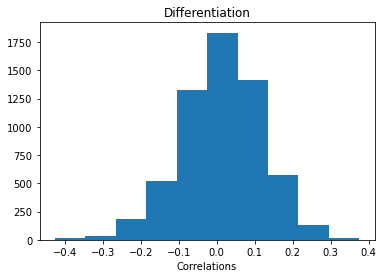

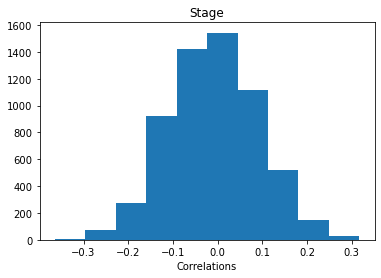

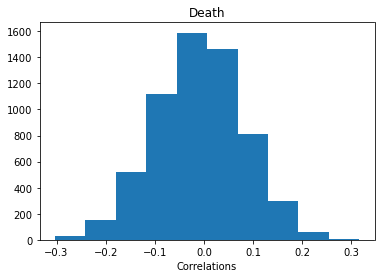

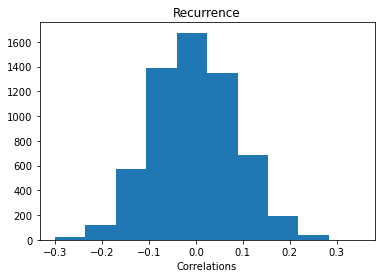

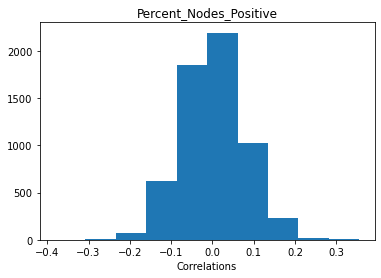

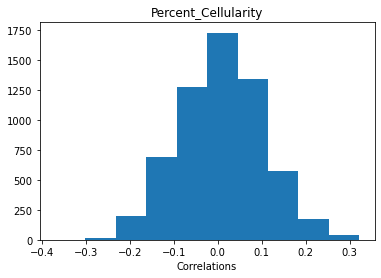

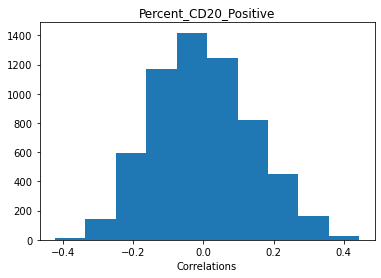

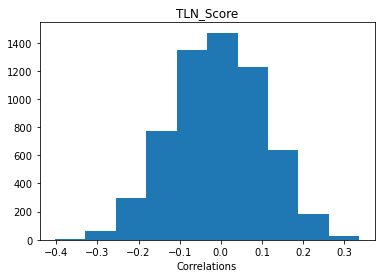

In [33]:
for name in Y.columns:
    corrs = []
    for xidx in range(X.shape[1]):
        corrs.append(np.corrcoef(X.iloc[:, xidx], Y.loc[:,name])[0,1])

    corrs = np.array(corrs)
    plt.hist(corrs)
    plt.title(name)
    plt.xlabel('Correlations')
    plt.show()

<AxesSubplot:>

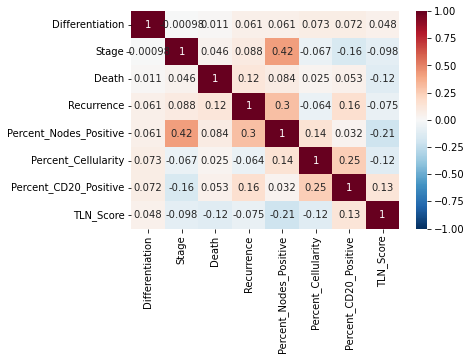

In [34]:
sns.heatmap(Y.corr(), cmap='RdBu_r', vmin=-1, center=0, vmax=1, annot=True)

Hmm...looks like all of the correlations are very weak, with the majority of genes being totally uncorrelated with each outcome. To get around this and still be able to build useful models, let's select out all genes that have *somewhat reasonable* correlations (aka. |R| >= 0.2). Hopefully the combination of a bunch of weakly correlated variables will produce a strong overall model.

Additionally, since most of the dependent variables are weakly correlated, trying to pick genes which have correlation >= 0.2 for ALL Y variables will eliminate nearly all variables. Therefore, it would be best to fit a separate model for each of the 8 variables.

Side Note: I tested LogisticRegression, PLSRegression, and RandomForestClassifier models on arbitrary subsets of data to find the best overall model. LogisticRegression worked great for classification variables, but wasn't flexible and needed an intermediate PCA transformation which adds complexity. RandomForest models have an inherent tendency to overfit on this dataset (consistently yield a perfect training accuracy but very poor test accuracy). Thus, I settled on PLSRegression and PLSDA for all variables.

### Helper functions and Classes

Below, I will be defining abstracted functions and classes that will greatly speed up the process of fitting 8 separate models. I will be creating a new PLSClassifier sklearn model for PLSDA, a PLS_CV helper function that automatically finds the best number of components and runs train and test sets, and a cv_score helper which does k-fold CV and computes the inputted scoring function

In [35]:
def cv_score(model, scorer, X, Y, kfold=5, random_state=None):
    """
    Q^2 score for univariate Y matrix.
    """
    kf = KFold(n_splits=kfold, shuffle=True, random_state=random_state)
    Y_hat = np.zeros(Y.shape[0])
    for train_idx, test_idx in kf.split(X):
        X_train = X[train_idx, :]
        X_test =  X[test_idx, :]
        Y_train = Y[train_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, Y_train)
        Y_hat[test_idx] = model.predict(X_test)[:,0]
    
    return scorer(Y, Y_hat)

In [36]:
def PLS_CV(X, Y, classifier=False, train_size=0.8, random_state=None):
    model_class = PLSRegression
    scoring = 'r2'
    score_fx = r2_score
    if classifier:
        model_class = PLSClassifier
        scoring = 'accuracy'
        score_fx = accuracy_score
    
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('predictor', model_class())])
    gs = GridSearchCV(estimator=pipe, param_grid={'predictor__n_components':np.arange(2,16,2)}, 
                      cv=KFold(n_splits=5, shuffle=True, random_state=random_state), scoring=scoring)
    gs.fit(X, Y)

    ncomp = gs.best_params_['predictor__n_components']
    model = model_class(n_components=ncomp)
    print(f'Best model was {model} with score {gs.best_score_}')
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, Y_train)
    print(f'Train Performance: {score_fx(Y_train, model.predict(X_train))}')
    print(f'Test Performance: {cv_score(model, score_fx, X.to_numpy(), Y.to_numpy(), random_state=random_state)}')

    return model

In [37]:
class PLSClassifier(TransformerMixin, ClassifierMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=self.n_components)
    
    def fit(self, X, Y):
        enc = OneHotEncoder()
        if not isinstance(Y, np.ndarray):
            Y = np.array(Y)
        Y_proba = enc.fit_transform(np.reshape(Y,(-1,1))).toarray()
        self.pls.fit(X, Y_proba)
        
        self.x_weights_ = self.pls.x_weights_
        self.x_loadings_ = self.pls.x_loadings_
        self.x_rotations_ = self.pls.x_rotations_
        self.y_weights_ = self.pls.y_weights_
        self.y_loadings_ = self.pls.y_loadings_
        self.y_rotations_ = self.pls.y_loadings_
        self.coef_ = self.pls.coef_

        return self

    def transform(self, X):
        return self.pls.transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X, Y).transform(X)

    def predict(self, X):
        pred_proba = self.pls.predict(X)
        return np.reshape(np.argmax(pred_proba, axis=1), (-1,1))

    def score(self, X, Y):
        return accuracy_score(Y, self.predict(X))

    def set_params(self, **params):
        for a in params:
            if a == 'n_components':
                self.pls.set_params(n_components=params[a])

    def __repr__(self):
        return f'PLSClassifier(n_components={self.n_components})'

    def __str__(self):
        return repr(self)

In [38]:
def feature_selection(X, Y, name, thresh):
    corrs = []
    for xidx in range(X.shape[1]):
        corrs.append(np.corrcoef(X.iloc[:, xidx], Y.loc[:,name])[0,1])
    corrs = np.array(corrs)
    corrs_sel = np.abs(corrs) >= thresh
    X_sel = X.loc[:, corrs_sel]
    return X_sel

In [39]:
def vip(model, labels, coef_col=0):
    Q = model.y_loadings_[0,:]
    T = model.x_scores_
    W = model.x_weights_
    nvars, ncomp = W.shape
    vips = np.zeros(nvars)

    q2tt = Q**2 * np.diag(T.T @ T)

    for i in range(nvars):
        weights = np.array([(W[i,j]/np.linalg.norm(W[:,j]))**2 for j in range(ncomp)])
        VIP = np.sqrt(nvars * np.sum(q2tt*weights)/np.sum(q2tt))
        vips[i]= VIP
    
    vips = pd.DataFrame({'VIP': vips, 'coef':model.coef_[:,coef_col]}, index = labels)
    return vips.sort_values(by='VIP', ascending=False)

### Model Fitting and Evaluation

In [40]:
gp = GProfiler(return_dataframe=True)

In [41]:
def do_analysis(X, Y, name, thresh, classifier):
    #select most correlated variables
    X_sel = feature_selection(X, Y, name, thresh)
    #get model with optimized n_components and do CV
    model = PLS_CV(X_sel, Y[name], classifier=classifier)
    #fit final model on full data
    model.fit(X_sel, Y[name])

    if classifier:
        vip_table = vip(model.pls, X_sel.columns, coef_col=1)
    else:
        vip_table = vip(model, X_sel.columns, coef_col=0)

    vip_genes_up = list(vip_table.loc[(vip_table['coef'] > 0) & (vip_table['VIP'] >= 1)].index)
    vip_genes_down = list(vip_table.loc[vip_table['coef'] < 0 & (vip_table['VIP'] >= 1)].index)
    print('\nTOP VIP SCORES')
    print(vip_table[0:15])

    go_up = gp.profile(query=vip_genes_up, organism='hsapiens')
    go_down = gp.profile(query=vip_genes_down, organism='hsapiens')

    print(f'\nPositive Association with {name}')
    print(go_up[go_up['source'].str.contains('GO')].iloc[0:10, 1:4])
    print(f'\nNegative Association with {name}')
    print(go_down[go_down['source'].str.contains('GO')].iloc[0:10, 1:4])

    LV = model.transform(X_sel)
    sns.scatterplot(x=LV[:,0], y=LV[:,1], hue=Y[name])

    return model, vip_table

#### Death

Best model was PLSClassifier(n_components=2) with score 0.8523809523809524
Train Performance: 0.9883720930232558
Test Performance: 0.8518518518518519

TOP VIP SCORES
               VIP      coef
AIMP2     1.854839 -0.009220
JAK1      1.744658  0.009134
SERPINA6  1.664192  0.002778
AK1       1.647337  0.002116
SPTBN2    1.643118  0.002277
HSPH1     1.634154 -0.007795
CCDC13    1.621789  0.007939
SPTB      1.602683  0.001408
PTPN12    1.599587  0.008374
AFM       1.568332  0.002403
PZP       1.567878  0.002290
FAM208B   1.530821 -0.007708
AHSG      1.520679  0.001175
TF        1.501672  0.001992
DHTKD1    1.489148 -0.007813

Positive Association with Death
        native                                           name       p_value
0   GO:0072562                            blood microparticle  3.724504e-10
1   GO:0005737                                      cytoplasm  2.742020e-08
3   GO:0070062                          extracellular exosome  4.715086e-07
4   GO:1903561                   

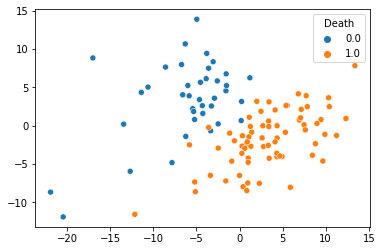

In [42]:
model_death, vips_death = do_analysis(X, Y, name='Death', thresh=0.15, classifier=True)

Enrichment for nucleotide binding and catalysis?

#### Recurrence

Best model was PLSClassifier(n_components=4) with score 0.8705627705627705
Train Performance: 1.0
Test Performance: 0.8888888888888888

TOP VIP SCORES
              VIP      coef
CCDC91   1.845390  0.026510
TMPRSS4  1.801291 -0.018835
ACADVL   1.766382  0.012402
NECTIN1  1.730736 -0.015238
MRPL50   1.614670 -0.014765
CISD3    1.612459  0.017706
AGPAT1   1.592805  0.021812
RRAS     1.578846  0.002224
GMPPB    1.517303  0.010424
PTPRZ1   1.505495 -0.017547
FAM83H   1.504899 -0.013813
CAV1     1.457280  0.006414
MBOAT7   1.441622 -0.016535
PAK1IP1  1.416004  0.012876
TRIM16L  1.396244  0.019767

Positive Association with Recurrence
        native                                      name   p_value
8   GO:0070062                     extracellular exosome  0.002434
9   GO:1903561                     extracellular vesicle  0.002895
10  GO:0043230                   extracellular organelle  0.002917
11  GO:0065010  extracellular membrane-bounded organelle  0.002917

Negative Association with R

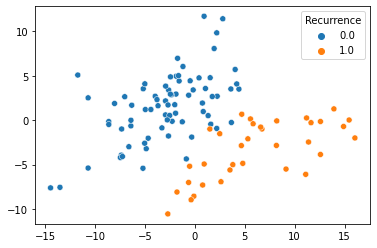

In [43]:
model_recur, vips_recur = do_analysis(X, Y, name='Recurrence', thresh=0.15, classifier=True)

Strong positive enrichment for DNA replication and negative enrichment for lysosome and lysis!

#### Tertiary Lymph Nodes (TLNs)

Best model was PLSClassifier(n_components=4) with score 0.5653679653679654
Train Performance: 0.872093023255814
Test Performance: 0.5740740740740741

TOP VIP SCORES
                VIP      coef
TSPO       2.685300 -0.011027
EXOC3L4    2.248783  0.005251
MTHFD1     2.185622  0.015384
ACSS3      2.119427 -0.008805
HMGN3      2.093138  0.002849
BID        2.002083 -0.013009
SMCO4      1.938951  0.015987
NOP14      1.925992  0.004600
AP3D1      1.899086 -0.001800
MRPL9      1.819661 -0.001039
CLIC1      1.813270  0.000976
MAX        1.763451  0.006152
SYNCRIP.1  1.763155  0.010637
KIF5B      1.726515 -0.000204
BRK1       1.687482 -0.001417

Positive Association with TLN_Score
       native                                               name       p_value
0  GO:1904874  positive regulation of telomerase RNA localiza...  7.009133e-20
1  GO:1904872  regulation of telomerase RNA localization to C...  1.015003e-18
2  GO:0101031                                  chaperone complex  1.272238e-18
3 

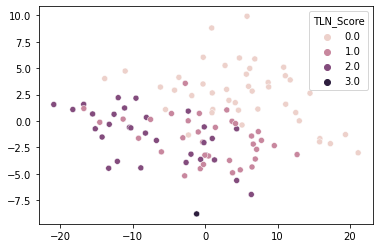

In [44]:
model_tln, vips_tln = do_analysis(X, Y, name='TLN_Score', thresh=0.20, classifier=True)

Ignore pathway enrichment

#### Differentiation

Best model was PLSRegression(n_components=4) with score 0.4905556255084532
Train Performance: 0.9463532546629485
Test Performance: 0.4492273582508105

TOP VIP SCORES
               VIP      coef
C17orf75  1.666311 -0.031628
PPP2R1B   1.506168  0.021965
PLAA      1.503241  0.025473
KRT3      1.457252 -0.007549
KRT6A     1.457002 -0.000242
KRT6B     1.455845 -0.000466
KRT6C     1.453149 -0.000266
DSG3      1.446179  0.005764
JUP       1.420946  0.007096
PKP1      1.413637  0.000015
KRT76     1.393658 -0.002342
DSC3      1.388937  0.004195
GBP6      1.378621  0.011073
KRT2      1.368248 -0.000440
SAMD9L    1.366233  0.011229

Positive Association with Differentiation
       native                                               name       p_value
0  GO:0005737                                          cytoplasm  2.491888e-10
1  GO:0008106             alcohol dehydrogenase (NADP+) activity  9.738083e-09
2  GO:0016616  oxidoreductase activity, acting on the CH-OH g...  3.341640e-08
3  GO:00040

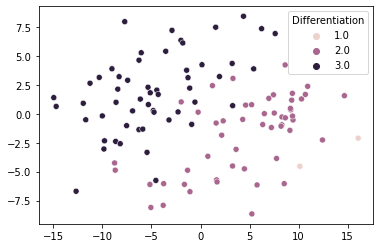

In [45]:
model_diff, vips_diff = do_analysis(X, Y, name='Differentiation', thresh=0.20, classifier=False)

Positive enrichment for ER and negative enrichment for fibrinogen, clotting? apoptosis?

#### Stage

Best model was PLSRegression() with score 0.5379405097240864
Train Performance: 0.7653470512703726
Test Performance: 0.5157233471138846

TOP VIP SCORES
               VIP      coef
BRD2      2.158068 -0.033085
ACSS3     1.961040  0.030405
PLIN2     1.835821  0.029528
MRPL3     1.643297 -0.025403
SELENBP1  1.606196  0.009994
WDR11     1.584499  0.025362
ASNA1     1.565937  0.025545
AOC3      1.540263  0.007724
STK38L    1.517568  0.023931
PRKAG1    1.495880  0.023738
TOE1      1.447417  0.008080
TGM2      1.436622  0.008119
ADH1B     1.414845  0.005181
NEDD4L    1.394568  0.022416
EHD2      1.378040  0.006723

Positive Association with Stage
        native                                            name   p_value
0   GO:0070062                           extracellular exosome  0.000011
1   GO:1903561                           extracellular vesicle  0.000013
2   GO:0043230                         extracellular organelle  0.000013
3   GO:0065010        extracellular membrane-bounded organe

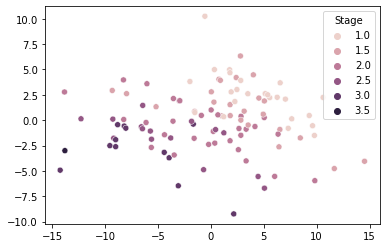

In [46]:
model_stage, vips_stage = do_analysis(X, Y, name='Stage', thresh=0.20, classifier=False)

Strong positive enrichment of mitochondrial function and negative enrichment of oxidoreductase, dehydrogenase activity.

#### Percentage of Lymph Nodes w/ Positive Metastasis

In [47]:
name = 'Percent_Nodes_Positive'
thresh = 0.20
classifier = False
X_sel = feature_selection(X, Y, name, thresh)
model = PLS_CV(X_sel, Y[name], classifier=classifier)

Best model was PLSRegression() with score -0.4153615872215523
Train Performance: 0.6513550709828596
Test Performance: 0.22493437015021178


Poor model, bad fit. Dropping this variable

#### Percentage of CD20 Positive Cells

Best model was PLSRegression(n_components=14) with score 0.1132092290330295
Train Performance: 0.9999826141536475
Test Performance: 0.24607466401626776

TOP VIP SCORES
               VIP      coef
INTS8     2.529347 -0.530656
EXOC8     2.446179 -0.402545
TNN       2.366173  0.456684
NDUFA3    2.234969 -0.338329
SNRPC     2.207488  0.168458
S100A16   2.110815 -0.161364
HMGN1     2.071132 -0.185191
NIP7      2.061940  0.212081
INSR      1.971975  0.409701
WDR81     1.969883 -0.339369
S100A14   1.950341 -0.080984
H6PD      1.949178 -0.296003
SYNE1     1.892460 -0.190947
POFUT2    1.886323 -0.372866
KIAA1551  1.864436  0.378706

Positive Association with Percent_CD20_Positive
        native                                      name       p_value
0   GO:0070062                     extracellular exosome  2.138143e-08
1   GO:1903561                     extracellular vesicle  2.919867e-08
2   GO:0065010  extracellular membrane-bounded organelle  2.959392e-08
3   GO:0043230                   ex

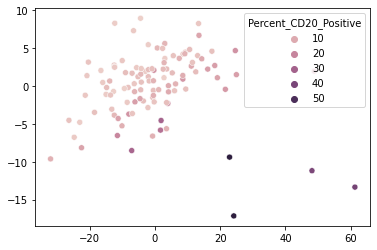

In [48]:
model_cd20, vips_cd20 = do_analysis(X, Y, name='Percent_CD20_Positive', thresh=0.20, classifier=False)

Strong positive enrichment of ribosomal function. Unreliable negative enrichment, but cycles between vesicles and ribosomes (again). 

#### Percent Tumor Cellularity

Best model was PLSRegression(n_components=4) with score 0.5510667178099999
Train Performance: 0.9256460202154255
Test Performance: 0.5400388978699375

TOP VIP SCORES
              VIP      coef
MYH7B    1.529596  0.605403
EFHD1    1.397921 -0.279824
GSK3A    1.367635  0.484473
TLR7     1.365513  0.412270
NCALD    1.358301  0.502256
RNPEP    1.335760 -0.336201
TMED1    1.328940 -0.234932
SKOR1    1.322612  0.211437
AIM1     1.272833 -0.523488
SDK1.1   1.241610 -0.298955
APBB1IP  1.236581  0.098732
KIF1C    1.231365 -0.457831
RPL32    1.225875  0.188293
RNF213   1.220251 -0.123327
MAT2A    1.219087  0.232873

Positive Association with Percent_Cellularity
        native                                name   p_value
0   GO:0005737                           cytoplasm  0.000035
1   GO:0005829                             cytosol  0.000358
10  GO:0006955                     immune response  0.030673
13  GO:0043202                     lysosomal lumen  0.036797
16  GO:0098542  defense response t

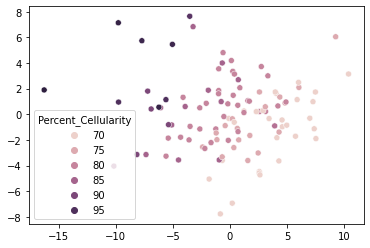

In [49]:
model_cellularity, vips_cellularity = do_analysis(X, Y, name='Percent_Cellularity', thresh=0.20, classifier=False)

Cytoplasm? Not good pathway enrichment